In [50]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from scipy.stats import norm
import numpy as np
from statsmodels.stats.weightstats import ztest
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [4]:
csv_file = os.getenv('HOME') + '/Aiffel/Exploration/20_anomaly_detection/nasdaq/nasdaq.csv'

df = pd.read_csv(csv_file)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6166,2020-10-20,11697.500000,11792.000000,11598.5,11660.799805,11660.799805,622702.0
6167,2020-10-21,11675.200195,11779.200195,11585.0,11691.200195,11691.200195,599851.0
6168,2020-10-22,11683.500000,11724.000000,11511.0,11649.799805,11649.799805,583669.0
6169,2020-10-23,11669.200195,11691.799805,11551.0,11663.500000,11663.500000,583669.0
6170,2020-10-25,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6171 entries, 0 to 6170
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6171 non-null   object 
 1   Open       5098 non-null   float64
 2   High       5098 non-null   float64
 3   Low        5098 non-null   float64
 4   Close      5098 non-null   float64
 5   Adj Close  5098 non-null   float64
 6   Volume     5098 non-null   float64
dtypes: float64(6), object(1)
memory usage: 337.6+ KB


In [6]:
df.loc[:, 'Date'] = pd.to_datetime(df.Date)

In [7]:
df.isna().sum()

Date            0
Open         1073
High         1073
Low          1073
Close        1073
Adj Close    1073
Volume       1073
dtype: int64

In [8]:
print(f'삭제 전 데이터 길이 : {len(df)}')
df = df.dropna(axis=0).reset_index(drop=True)

print(f'삭제 후 데이터 길이 : {len(df)}')
df.isna().sum()

삭제 전 데이터 길이 : 6171
삭제 후 데이터 길이 : 5098


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

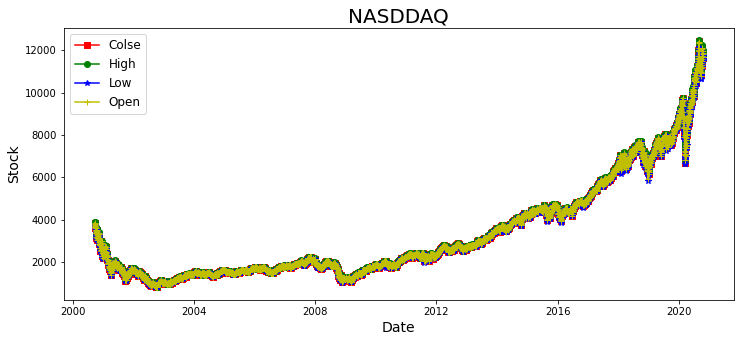

In [11]:
plt.rcParams['figure.figsize'] =(12, 5)

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('NASDDAQ', fontsize=20)
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Colse', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

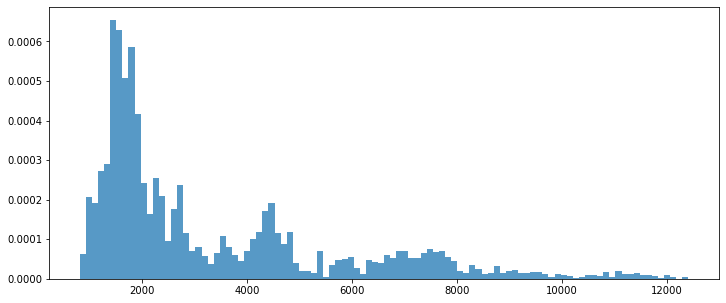

In [26]:
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

In [27]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


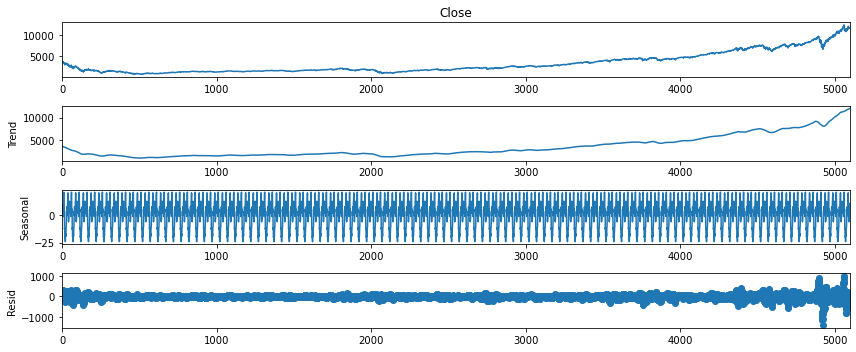

In [28]:
result = seasonal_decompose(df.Close, model='additive', two_sided=True, period=50, extrapolate_trend='freq')
result.plot()
plt.show()

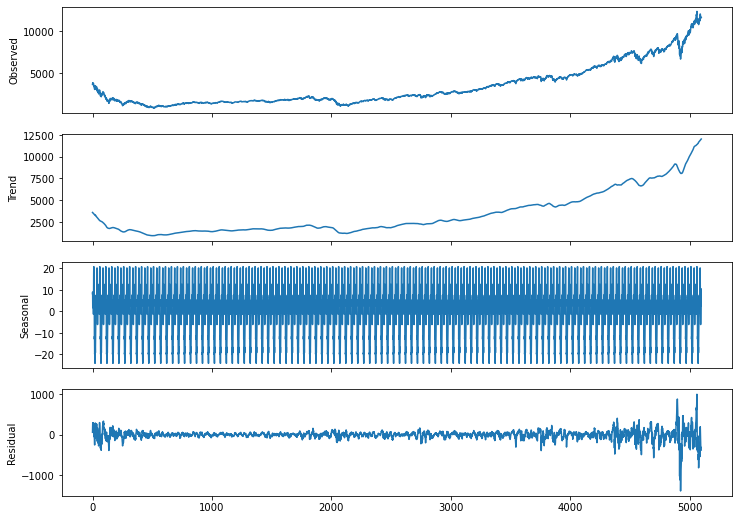

In [31]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

<AxesSubplot:>

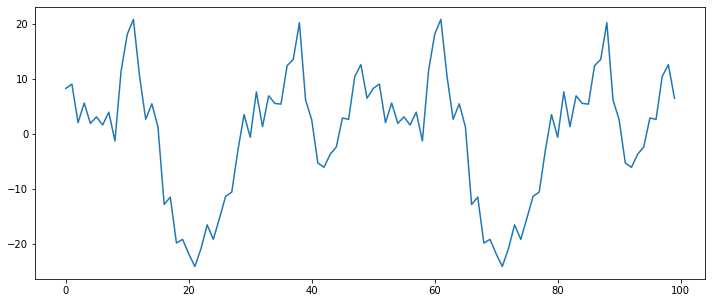

In [32]:
result.seasonal[:100].plot()

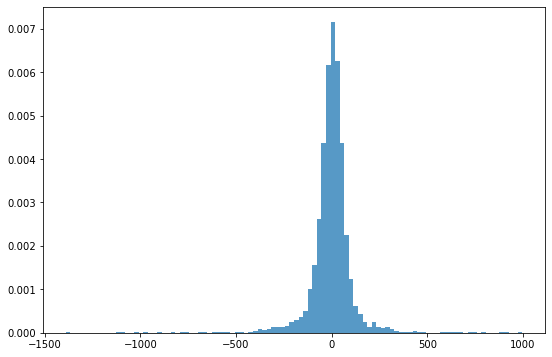

In [33]:
fig, ax = plt.subplots(figsize=(9, 6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [36]:
r = result.resid.values
st, p = ztest(r)
print(st, p)

-0.8390076883668717 0.4014649952251901


In [39]:
mu, std = result.resid.mean(), result.resid.std()
print('평균:', mu, '표준편차:', std)

print('이상치 갯수:', len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -1.2913972051413372 표준편차: 109.8990193543672
이상치 갯수: 92


In [44]:
ls = list(df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index])

In [45]:
print(ls)

[Timestamp('2000-12-20 00:00:00'), Timestamp('2001-01-02 00:00:00'), Timestamp('2001-01-29 00:00:00'), Timestamp('2001-01-30 00:00:00'), Timestamp('2001-04-03 00:00:00'), Timestamp('2001-04-04 00:00:00'), Timestamp('2015-08-24 00:00:00'), Timestamp('2015-08-25 00:00:00'), Timestamp('2018-02-08 00:00:00'), Timestamp('2018-02-09 00:00:00'), Timestamp('2018-03-09 00:00:00'), Timestamp('2018-03-12 00:00:00'), Timestamp('2018-04-02 00:00:00'), Timestamp('2018-10-29 00:00:00'), Timestamp('2018-12-03 00:00:00'), Timestamp('2018-12-21 00:00:00'), Timestamp('2018-12-26 00:00:00'), Timestamp('2018-12-28 00:00:00'), Timestamp('2019-01-03 00:00:00'), Timestamp('2019-05-29 00:00:00'), Timestamp('2019-05-31 00:00:00'), Timestamp('2019-06-03 00:00:00'), Timestamp('2019-06-04 00:00:00'), Timestamp('2019-06-05 00:00:00'), Timestamp('2019-08-05 00:00:00'), Timestamp('2020-02-10 00:00:00'), Timestamp('2020-02-11 00:00:00'), Timestamp('2020-02-12 00:00:00'), Timestamp('2020-02-13 00:00:00'), Timestamp('20

In [46]:
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    for f in features:
        result = seasonal_decompose(df[f], model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

tdf, sdf, rdf = my_decompose(df, features=['Open', 'High', 'Low', 'Close', 'Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,3330.724999,3362.220146,3298.532406,3332.609090,288057.188854
std,2400.892883,2422.863050,2379.665832,2404.825139,109834.091507
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.407500,1597.671250,1571.153750,1584.352001,220586.700000
50%,2264.797500,2292.105000,2232.207500,2265.174199,268932.110000
75%,4434.168125,4466.316875,4401.132500,4435.347500,319674.830000
max,12039.860297,12201.437499,11870.369861,12047.090432,776809.340000


In [47]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,-1.361168,-1.421971,-1.241082,-1.314223,155.136515
std,112.249407,102.051145,116.463672,110.054996,110706.241180
min,-1280.580676,-1494.706438,-1226.976539,-1390.196689,-602731.340129
25%,-38.117788,-35.393102,-38.318769,-37.788724,-53311.671523
50%,3.476876,3.331959,4.089242,2.923191,-488.997470
75%,40.164011,37.638459,41.675332,40.863314,51480.694345
max,996.954616,933.609579,944.823580,996.320780,810713.135421


In [49]:
scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.36116811  -1.42197139  -1.24108161  -1.31422283 155.13651478]


array([[ 0.94892246,  0.84646493,  0.81728626,  0.60184276,  0.08322602],
       [ 0.49026957,  1.28420778,  1.38842808,  2.09551792,  0.10454779],
       [ 1.90750707,  2.01838985,  2.0481367 ,  2.7378712 , -0.08888583],
       ...,
       [-2.9355638 , -3.75950684, -2.18973446, -2.93558305,  0.44805172],
       [-3.02900188, -4.45234664, -3.01260131, -3.46542972,  0.39484453],
       [-3.32615554, -5.03188414, -2.82731937, -3.56760069,  0.48127544]])

In [51]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_)

[1 1 1 ... 0 0 0]


In [52]:
lbl, cnt = np.unique(kmeans.labels_, return_counts=True)
print(lbl)
print(cnt)

[0 1]
[1099 3999]


In [55]:
kmeans=KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_, return_counts=True)
[f'group : {group} - count : {count}' for group, count in zip(lbl, cnt)]

['group : 0 - count : 1008',
 'group : 1 - count : 66',
 'group : 2 - count : 1097',
 'group : 3 - count : 18',
 'group : 4 - count : 296',
 'group : 5 - count : 495',
 'group : 6 - count : 459',
 'group : 7 - count : 33',
 'group : 8 - count : 19',
 'group : 9 - count : 831',
 'group : 10 - count : 331',
 'group : 11 - count : 98',
 'group : 12 - count : 11',
 'group : 13 - count : 98',
 'group : 14 - count : 238']

In [65]:
df[(kmeans.labels_==8)| (kmeans.labels_==12)]

,Date,Open,High,Low,Close,Adj Close,Volume
4891,2020-02-11,9525.000000,9609.500000,9501.250000,9527.250000,9527.250000,589570.0
4892,2020-02-12,9536.250000,9628.250000,9523.750000,9625.750000,9625.750000,454472.0
4893,2020-02-13,9621.500000,9644.750000,9511.250000,9613.000000,9613.000000,613580.0
4894,2020-02-14,9626.250000,9659.250000,9588.000000,9632.250000,9632.250000,489387.0
4895,2020-02-16,9635.000000,9668.750000,9634.250000,9663.750000,9663.750000,297278.0
4896,2020-02-18,9635.000000,9687.500000,9534.250000,9636.000000,9636.000000,668505.0
4897,2020-02-19,9643.250000,9748.750000,9641.250000,9733.500000,9733.500000,419130.0
4898,2020-02-20,9744.750000,9763.000000,9517.000000,9624.250000,9624.250000,802424.0
4899,2020-02-21,9617.250000,9623.750000,9411.500000,9458.000000,9458.000000,911839.0
4900,2020-02-23,9355.250000,9365.000000,9289.000000,9315.000000,9315.000000,995989.0


In [60]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000,5.098000e+03
mean,3329.358747,3360.794284,3297.286767,3331.291122,3331.291122,2.882167e+05
std,2400.978546,2422.128357,2380.456260,2404.769584,2404.769584,1.595897e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1593.500000,1608.500000,1576.500000,1593.125000,1593.125000,1.907512e+05
50%,2232.000000,2259.875000,2211.750000,2232.875000,2232.875000,2.657315e+05
75%,4447.000000,4469.875000,4419.437500,4451.187500,4451.187500,3.562115e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


In [62]:
pd.DataFrame(kmeans.cluster_centers_, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

,Open,High,Low,Close,Volume
0,0.194578,0.193084,0.252013,0.233630,-0.443905
1,-1.333821,-1.483672,-2.026410,-2.027606,3.052986
2,-0.234961,-0.237032,-0.220148,-0.218888,0.175160
3,2.867673,2.755949,2.001638,1.941786,2.835088
4,-0.019224,-0.041160,-0.306351,-0.279899,1.701011
5,0.868996,0.903342,0.935606,0.923896,-0.310361
6,-0.899405,-0.912158,-0.888788,-0.866056,0.467757
7,-4.195611,-4.554132,-4.181233,-4.167360,0.790436
8,6.092861,6.187818,6.208749,6.171515,-0.432828
9,0.316971,0.346216,0.271677,0.288842,0.449370


In [ ]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
